In [14]:
import numpy as np
import vpsto.vptraj_jax as jvptraj

import matplotlib.pyplot as plt
from matplotlib import animation

import jax.numpy as jnp
from jax import jit, random
from functools import partial

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
q0 = np.array([-.5, -.5]) # Initial position
qg = np.array([.5, .5]) # Goal position
dq0 = np.array([0, 0]) # Initial velocity
dqg = np.array([0, 0]) # Goal velocity

bounds = 0.8*np.array([[-1, 1], [-1, 1]]) # Bounds on position

R = 1e1 # Penalty on control effort (acceleration)
Q_min = 1e0 # Minimum penalty on control error (position)
Q_max = 1e3 # Maximum penalty on control error (position)
factor_Q_min = 1e-2
factor_Q_max = 1e1

N_via = 4 # Number of via points
N_candidates = 1000 # Number of candidates to sample
N_eval = 50 # Number of pos,vel,acc samples to evaluate along each candidate trajectory

vel_lim = 0.4 # Velocity limit (m/s in each dimension)
acc_lim = 1 # Acceleration limit (m/s^2 in each dimension)

num_obstacles = 10 # Number of obstacles
robot_radius = 0.1 # Radius of robot (m)
obstacle_radius = 0.1 # Radius of obstacle (m)

dt_control = 0.05 # Time step for control (s)
sim_duration = 10 # Duration of simulation (s)

mu_prior = np.zeros(N_via*2) # Prior mean
P_prior = np.zeros((N_via*2, N_via*2)) # Prior precision

key = random.PRNGKey(0)

In [16]:
class Obstacle:
    def __init__(self, pos, vel, radius, robot_radius):
        self.pos = pos # initial position
        self.vel = vel # initial velocity
        self.radius = radius # radius of obstacle
        self.robot_radius = robot_radius # radius of robot
        self.d_sq = (radius + robot_radius + 0.01)**2 # distance squared for faster collision checking

        self.history = [self.pos.copy()] # history of obstacle positions

    def reset(self):
        self.history = [self.pos.copy()]

    def step(self, dt):
        # Check if obstacle would bounce off a wall and reverse velocity if so
        for i in range(2):
            if self.pos[i] + self.vel[i] * dt < bounds[i, 0] + self.radius:
                self.vel[i] = -self.vel[i]
            if self.pos[i] + self.vel[i] * dt > bounds[i, 1] - self.radius:
                self.vel[i] = -self.vel[i]
        self.pos += self.vel * dt
        self.history.append(self.pos.copy())

    def is_collision(self, robot_pos):
        # Check if the robot at pos is in collision with the obstacle
        # pos is a (N+1)D array of shape (M1, ..., MN, 2)
        # Returns a ND array of shape (M1, ..., MN) containing True if there is a collision
        return np.sum((robot_pos - self.pos)**2, axis=-1) < self.d_sq
    
    def predict_collision(self, robot_pos_traj, T):
        # Predict if there will be a collision in the next T seconds
        # pos_traj is a 2D array of shape (N, 2) containing the discretized trajectory of the robot
        # T is a scalar
        # Returns the number of collisions in the next T seconds
        N = robot_pos_traj.shape[0]
        t_traj = np.linspace(0, T, N)
        obs_traj = self.pos + self.vel * t_traj[:, None]
        return np.sum((robot_pos_traj - obs_traj)**2, axis=-1) < self.d_sq
    
    def predict_collision_batch(self, robot_pos_traj, T):
        # Predict if there will be a collision in the next T seconds
        # pos_traj is a 3D array of shape (N_batch, N, 2) containing the discretized trajectories of the robot
        # T is a vector of shape (N_batch,)
        # Returns the number of collisions in the next T seconds for each batch element
        N_batch, N, _ = robot_pos_traj.shape
        t_traj = np.linspace(0, T, N)
        obs_traj = self.pos + np.swapaxes(self.vel * t_traj[:, :, None], 0, 1) # (N_batch, N, 2)
        return np.sum((robot_pos_traj - obs_traj)**2, axis=-1) < self.d_sq

In [17]:
def batched_collision_loss_fn(T_batch, q_robot_batch, radius_robot, x_obs_batch, radius_obs):
    # T_batch, (batch_size,)
    # x_robot_batch, (batch_size, N_eval, 2)
    # x_obs_batch, (num_obstacles, 4)
    # Predict the obstacle positions for the given horizons
    batch_size, N_eval, ndof = q_robot_batch.shape
    num_obstacles, _ = x_obs_batch.shape
    t_horizon = jnp.linspace(0, T_batch, N_eval).T # (batch_size, N_eval)
    t_horizon = jnp.repeat(t_horizon[:, :, None], ndof, axis=-1) # (batch_size, N_eval, ndof)
    t_horizon = jnp.repeat(t_horizon[None, :, :, :], num_obstacles, axis=0) # (num_obstacles, batch_size, N_eval, ndof)
    x_obs_batch = x_obs_batch[:, None, None, :] # (num_obstacles, 1, 1, 2*ndof)
    x_obs_batch = jnp.repeat(x_obs_batch, batch_size, axis=1) # (num_obstacles, batch_size, 1, 2*ndof)
    x_obs_batch = jnp.repeat(x_obs_batch, N_eval, axis=2) # (num_obstacles, batch_size, N_eval, 2*ndof)
    q_obs_batch = x_obs_batch[:, :, :, :ndof] + x_obs_batch[:, :, :, ndof:] * t_horizon # (num_obstacles, batch_size, N_eval, ndof)
    dist_sq = jnp.sum((q_robot_batch - q_obs_batch)**2, axis=-1) # (num_obstacles, batch_size, N_eval)
    return jnp.sum(dist_sq < (radius_robot + radius_obs + 0.01)**2, axis=(0, 2)) # (batch_size,)

def batched_target_loss_fn(q_robot_batch, qg):
    # q_robot_batch, (batch_size, N_eval, 2)
    # qg, (2,)
    return jnp.sum((q_robot_batch[:, -1, :] - qg)**2, axis=-1) # (batch_size,)

def batched_limit_loss_fn(q_robot_batch, radius_robot, bounds):
    # q_robot_batch, (batch_size, N_eval, 2)
    # bounds, (2, 2)
    return jnp.sum((q_robot_batch < bounds[:, 0] + radius_robot) | 
                   (q_robot_batch > bounds[:, 1] - radius_robot), axis=(1, 2)) # (batch_size,)

@jit
def batched_loss_fn(T_batch, q_robot_batch, radius_robot, x_obs_batch, radius_obs, qg, bounds):
    # T_batch, (batch_size,)
    # q_robot_batch, (batch_size, N_eval, 2)
    # x_obs_batch, (num_obstacles, 4)
    # qg, (2,)
    # bounds, (2, 2)
    return batched_collision_loss_fn(T_batch, q_robot_batch, radius_robot, x_obs_batch, radius_obs) * 1e6 + \
           batched_target_loss_fn(q_robot_batch, qg) * 1e3 + \
           batched_limit_loss_fn(q_robot_batch, radius_robot, bounds) * 1e3 + \
           T_batch

### Initialize obstacles and controller

In [18]:
# Initialize obstacles at random positions and velocities
obstacles = []
for i in range(num_obstacles):
    valid = False
    while not valid:
        pos = np.random.uniform(bounds[:, 0] + obstacle_radius, bounds[:, 1] - obstacle_radius)
        vel = np.random.uniform(-.1, .1, size=2)
        obs = Obstacle(pos, vel, obstacle_radius, robot_radius)
        valid = not obs.is_collision(q0)
    obstacles.append(obs)

In [19]:
@partial(jit, static_argnums=(0,1,2,))
def predictive_sampling(N_candidates, N_via, N_eval, q0, dq0, dqg, R, qg, Q, mu_prior, P_prior, key,
                        robot_radius, x_obs, obstacle_radius, bounds):
    p_samples = jvptraj.sample_via_points(N_candidates, N_via, q0, dq0, R, qg, Q, mu_prior, P_prior, key)
    T = jvptraj.batched_get_T_velacc(p_samples, q0, dq0, dqg, vel_lim, acc_lim)
    q, dq, ddq = jvptraj.batched_get_trajectory(N_eval, p_samples, T, q0, dq0, dqg)

    # Compute the loss for each candidate trajectory
    loss = batched_loss_fn(T, q, robot_radius, x_obs, obstacle_radius, qg, bounds)
    i_best = jnp.argmin(loss)

    return p_samples, T, loss, i_best

In [20]:
# Run controller for the first step
x_obs = np.concatenate(([obs.pos for obs in obstacles], [obs.vel for obs in obstacles]), axis=1)
p_samples, T, loss, i_best = predictive_sampling(N_candidates, N_via, N_eval, q0, dq0, dqg, R, qg, Q_min, mu_prior, P_prior, key,
                                                    robot_radius, x_obs, obstacle_radius, bounds)
q, dq, ddq = jvptraj.batched_get_trajectory(N_eval, p_samples, T, q0, dq0, dqg)

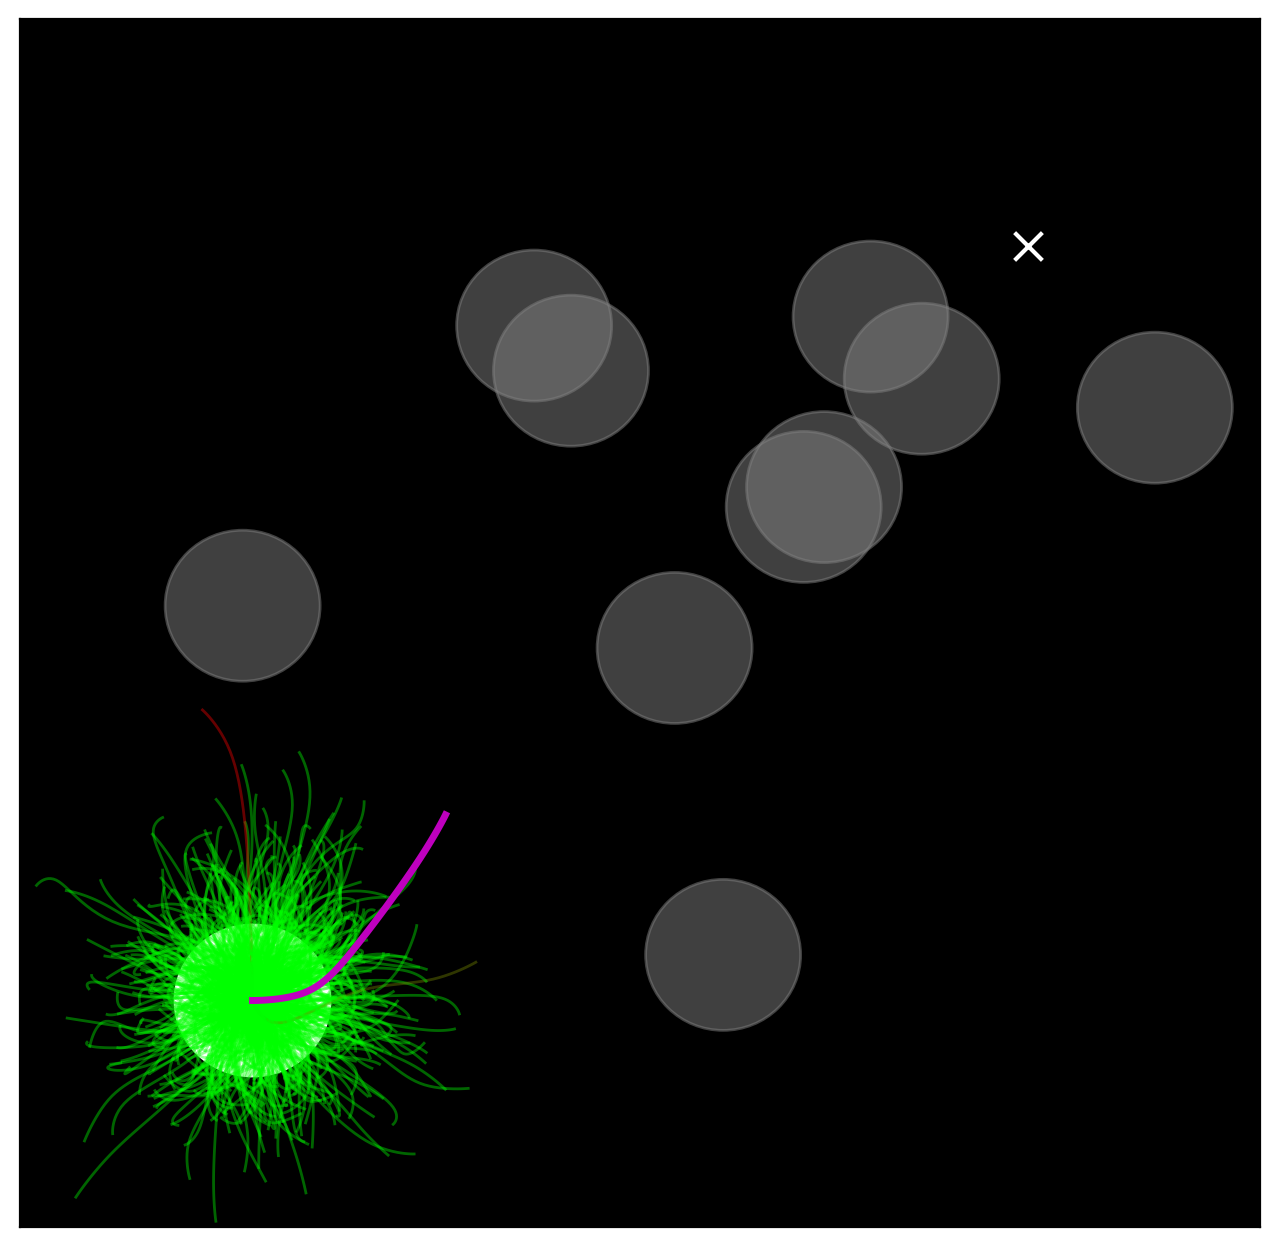

In [21]:
fig = plt.figure(figsize=(8,8), dpi=200)
ax = plt.gca()
ax.set_facecolor('k')
ax.set_xlim(bounds[0])
ax.set_ylim(bounds[1])
ax.set_xticks([])
ax.set_yticks([])

obstacle_paches = []
for obs in obstacles:
    obstacle_paches.append(plt.Circle(obs.pos, obs.radius, color='gray', alpha=.5))
    ax.add_patch(obstacle_paches[-1])

robot_patch = plt.Circle(q0, robot_radius, color='w', label='Robot')
ax.add_patch(robot_patch)
plt.scatter(qg[0], qg[1], c='w', marker='x', s=100, label='Goal')

rewards = np.array(1 - (loss - np.min(loss)) / (np.max(loss) - np.min(loss)))
for n in range(N_candidates):
    c = (1-float(rewards[n]), rewards[n], 0)
    ax.plot(q[n,:,0], q[n,:,1], color=c, lw=1, alpha=.4)

ax.plot(q[i_best,:,0], q[i_best,:,1], 'm', lw=2.5, label='Simulated trajectory', zorder=10)

### Simulate closed-loop system for *sim_duration* seconds

In [22]:
def control(q, dq, old_key):
    new_key, subkey = random.split(old_key)
    x_obs = np.concatenate(([obs.pos for obs in obstacles], [obs.vel for obs in obstacles]), axis=1)
    p_samples, T, loss, i_best = predictive_sampling(N_candidates, N_via, N_eval, q, dq, dqg, R, qg, Q_min, mu_prior, P_prior, subkey,
                                                     robot_radius, x_obs, obstacle_radius, bounds)
    q_next, dq_next, _ = jvptraj.get_trajectory_at_time(dt_control, p_samples[i_best], q, dq0=dq, 
                                                        dqT=np.zeros_like(dq), T=T[i_best])
    return q_next[0], dq_next[0], loss[i_best], new_key

In [23]:
q_sim = [q0]
dq_sim = [dq0]
I = int(sim_duration / dt_control)

In [24]:
for i in range(I):
    print(i/I, end='\r')
    for obs in obstacles:
        obs.step(dt_control) # Simulate obstacle motion
    x_obs = np.concatenate(([obs.pos for obs in obstacles], [obs.vel for obs in obstacles]), axis=1)
    key, subkey = random.split(key)
    p_samples, T, loss, i_best = predictive_sampling(N_candidates, N_via, N_eval, q_sim[-1], dq_sim[-1], dqg, R, qg, Q_min, mu_prior, P_prior, subkey,
                                                     robot_radius, x_obs, obstacle_radius, bounds)
    q_next, dq_next, _ = jvptraj.get_trajectory_at_time(dt_control, p_samples[i_best], q_sim[-1], dq0=dq_sim[-1], 
                                                        dqT=np.zeros_like(dq_sim[-1]), T=T[i_best])
    #q, dq, _, key = control(q_sim[-1], dq_sim[-1], key) # Compute next desired position and velocity
    # As we pretend we have a perfect low-level controller, we can directly apply the desired state
    q_sim.append(q_next[0].copy())
    dq_sim.append(dq_next[0].copy())

q_sim = np.array(q_sim)[1:]
dq_sim = np.array(dq_sim)[1:]

In [ ]:
%%timeit
control(q0, dq0, key) # Compute next desired position and velocity

23.8 ms ± 3.44 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%%timeit
p_samples, T, loss, i_best = predictive_sampling(N_candidates, N_via, N_eval, q0, dq0, dqg, R, qg, Q_min, mu_prior, P_prior, key,
                                                 robot_radius, x_obs, obstacle_radius, bounds)
q_next, dq_next, _ = jvptraj.get_trajectory_at_time(dt_control, mu_prior, q0, dq0=dq0, 
                                                    dqT=np.zeros_like(dq0), T=1.)
    

14.1 ms ± 1.33 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
%%timeit
q_next, dq_next, _ = jvptraj.get_trajectory_at_time(dt_control, mu_prior, q0, dq0=dq0, 
                                                    dqT=np.zeros_like(dq0), T=1.)

1.57 ms ± 86.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Visualize results

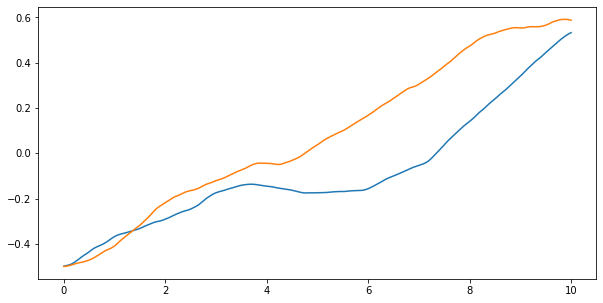

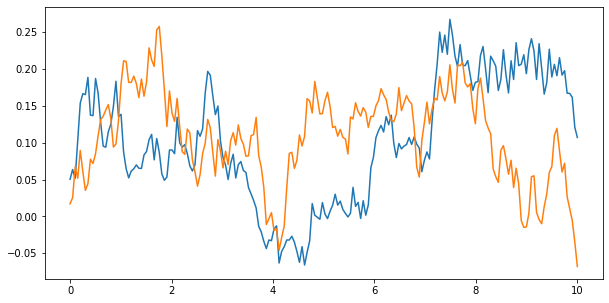

In [12]:
plt.figure(figsize=(10,5))
plt.plot(np.linspace(0, sim_duration, len(q_sim)), q_sim)

plt.figure(figsize=(10,5))
plt.plot(np.linspace(0, sim_duration, len(dq_sim)), dq_sim)

# plt.figure(figsize=(10,5))
# plt.plot(np.linspace(0, sim_duration, len(controller.Q_log)), np.log10(controller.Q_log))

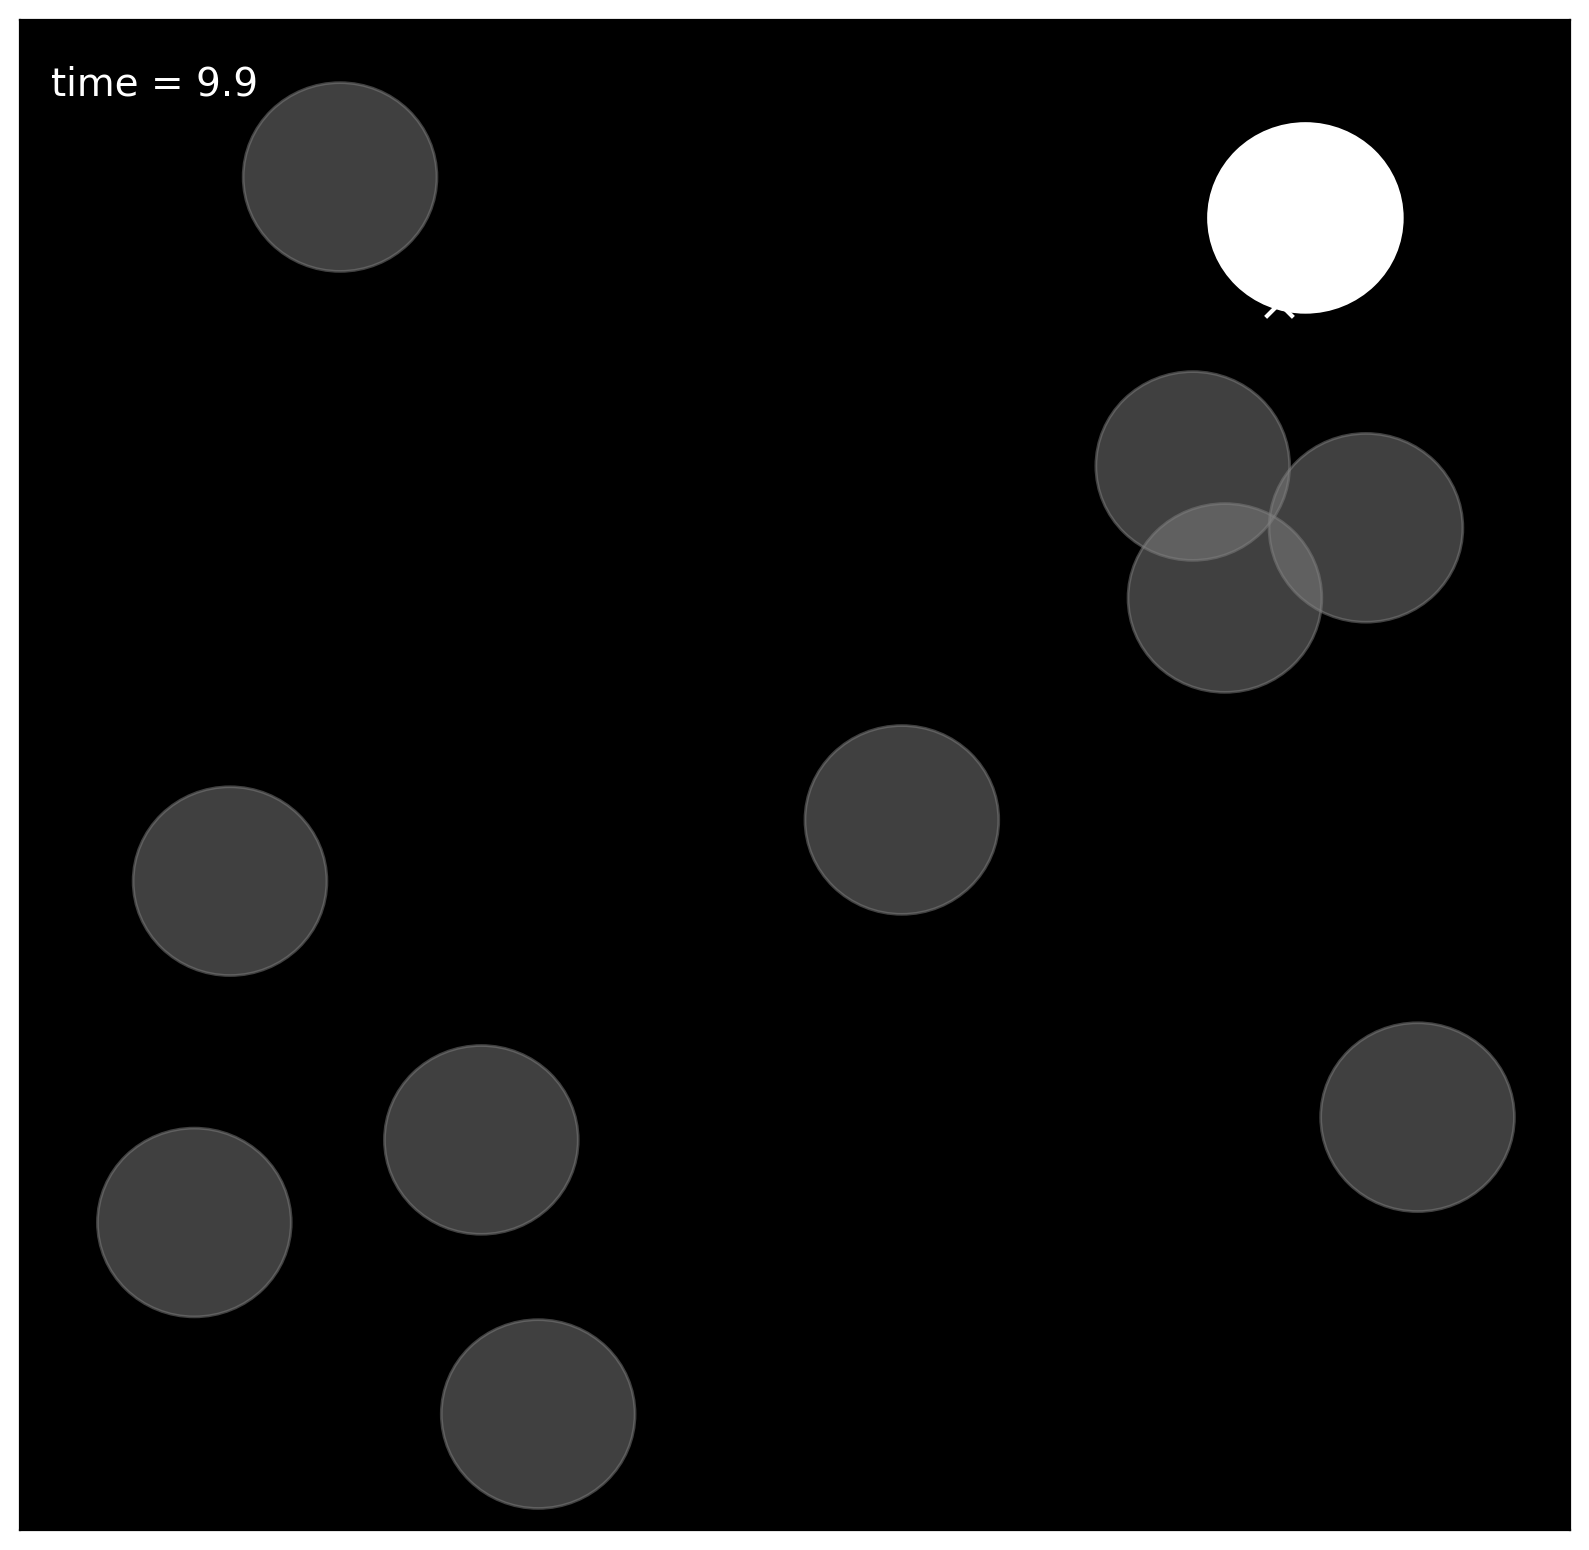

In [13]:
fps = 10

# Animate the simulation
fig = plt.figure(figsize=(10,10), dpi=200)
ax = plt.gca()
ax.set_facecolor('k')
ax.set_xlim(bounds[0])
ax.set_ylim(bounds[1])
ax.set_xticks([])
ax.set_yticks([])

obstacle_paches = []
for obs in obstacles:
    obstacle_paches.append(plt.Circle(obs.pos, obs.radius, color='gray', alpha=.5))
    ax.add_patch(obstacle_paches[-1])

robot_patch = plt.Circle(q0, robot_radius, color='w', label='Robot')
ax.add_patch(robot_patch)
plt.scatter(qg[0], qg[1], c='w', marker='x', s=100, label='Goal')

time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes, color='w', fontsize=14)

def init():
    time_text.set_text('')
    return time_text,

def animate(i_):
    i = np.min([len(q_sim)-1, int(i_ / (dt_control * fps))])
    robot_patch.center = q_sim[i]
    print(int(i/len(q_sim)*100), end='%\r')
    for j, obs in enumerate(obstacles):
        obstacle_paches[j].center = obs.history[i]
    time_text.set_text('time = %.1f' % (i*dt_control))
    return time_text,

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=int(len(q_sim) * dt_control * fps), interval=1e3/fps, blit=True)

anim.save('animation.mp4', fps=fps, extra_args=['-vcodec', 'libx264'])